In [9]:
import tqdm
import torch as th
from datetime import datetime
import numpy as np
from torch.optim import Adam

from PoisDenoiser.networks.PoisNet.net import PoisNet
from PoisDenoiser.dataset_loader import BSDS500
from PoisDenoiser.utils import show_images as show

from pydl.nnLayers.modules import PSNRLoss

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


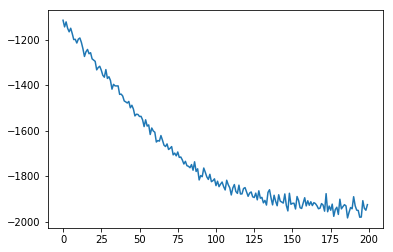

In [10]:
plt.plot(np.load('./train_losses.npy'))

In [2]:
def dt():
    return datetime.now().strftime('%H:%M:%S')

In [3]:
path2dataset = './DATASETS/BSDS500_Pois_crops/'

BSDStrain = BSDS500(path2dataset+'train/')
BSDStrain_loader = DataLoader(BSDStrain, batch_size=8, shuffle=True, num_workers=1)

BSDSval = BSDS500(path2dataset+'val/')
BSDSval_loader = DataLoader(BSDSval, batch_size=4, shuffle=False, num_workers=1)

gpu=1

In [4]:
model = PoisNet().cuda(gpu)

/home/davydov/Pois/pydl/nnLayers/init.py:57: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  data_samples = th.range(start,end,step).type_as(centers)


In [5]:
epochs = 10
k = 0.1
max_val = 1/k

optimizer = Adam(model.parameters(), lr=1e-4)

criterion = PSNRLoss(max_val).cuda(gpu)

for epoch in range(epochs):
    train_loss_arr = []
    for gt, noisy in BSDStrain_loader:

        gt = gt.cuda(gpu)
        noisy = noisy.cuda(gpu)

        prediction = model.forward(noisy, noisy)

        optimizer.zero_grad()
        loss = criterion(prediction, gt)
        cur_loss = loss.data.cpu().numpy().item()
        train_loss_arr.append(cur_loss)
        loss.backward()
        optimizer.step()

        print(dt(), '{} {}'.format(epoch, cur_loss))
        break

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fce24394080>>
Traceback (most recent call last):
  File "/home/davydov/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/davydov/miniconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/davydov/miniconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/davydov/miniconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/davydov/miniconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/davydov/miniconda3/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)